# Example 8.2: Low-pass filtering of signals

## Amplitude response

Signal processing in experiments often requires filtering to eliminate unwanted frequency components that can interfere with analysis. However, it's impossible to completely remove certain frequency content without affecting the frequencies of interest. Therefore, filters are designed to minimize interference with the desired frequency content while effectively suppressing the unwanted components.

The frequency-domain filter called $H(\omega)$ is applied to the original (raw) signal $x(\omega)$ as follows:

$$
x_f(\omega)=H(\omega)x(\omega)
$$

$x_f(\omega)$ is called the filtered signal.

In this note, we will study the Butterworth filter and how this is implemented in SciPy. The amplitude response of a Butterworth filter is defined as

$$ |H(\omega)| = \frac{1}{\sqrt{1+\left( \dfrac{\omega}{\omega_c} \right)^{2n}}} $$

Here $n$ is the filter order, and $\omega_c$ is the cutoff frequency. We will consider the normalized filter by assuming that the cutoff frequency is one. The figures below show the amplitude response of filters with different orders.

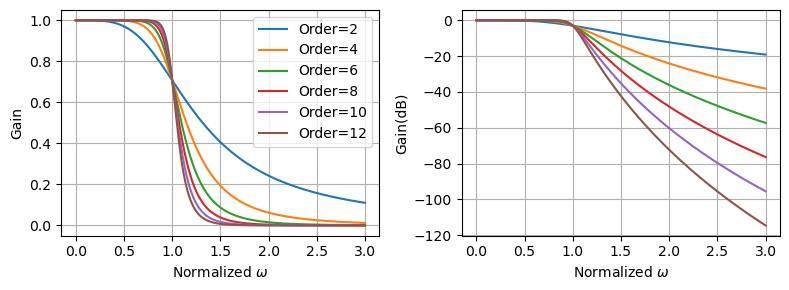

In [7]:
import numpy as np
from scipy import signal as spsp
from matplotlib import pyplot as plt

omega_axis_normalized = np.linspace(0,3,1001)
n_plot = [2, 4, 6, 8, 10, 12]

fig, axs = plt.subplots(1,2,figsize=(8,3))

for n in n_plot:
    amplitude_response = 1 /( (1+ omega_axis_normalized**(2*n))**0.5)
    axs[0].plot(omega_axis_normalized,amplitude_response, label = 'Order=' + str(n))
    axs[1].plot(omega_axis_normalized,20*np.log10(amplitude_response))
    
axs[0].legend()
axs[0].grid()
axs[0].set_ylabel('Gain')
axs[0].set_xlabel('Normalized $\omega$')

axs[1].grid()
axs[1].set_ylabel('Gain(dB)')
axs[1].set_xlabel('Normalized $\omega$')

fig.tight_layout()
plt.show()


The figures illustrate that the filter will not change the amplitudes of the lower frequencies, while the amplitudes of the higher frequencies are reduced significantly. The filter is thus a low pass filter. In low-pass signal filtering, we would like to keep the amplitudes of the frequency content below the cutoff frequency and remove the frequency content above it. This objective is not perfectly achieved for any of the filters, and it is vital to select the cutoff frequency and the filter order so that the filter performs as you prefer.

## Filter design

The equation for the filter amplitude response contains two parameters, the cutoff frequency $\omega_c$ and the filter order $n$. It is thus possible to define the filter using two points on the amplitude response curve of the filter. We start by considering the expression for the filter gain at two selected frequencies $\omega_p$ and $\omega_s$ ($s=$ stop, $p=$ pass).

$$ G_{p}^2 = \dfrac{1}{1+\left( \dfrac{\omega_{p}}{\omega_c} \right)^{2n}}
,
\qquad
G_{s}^2 = \dfrac{1}{1+\left( \dfrac{\omega_{s}}{\omega_c} \right)^{2n}} $$

Here, $p$ and $s$ denote the "passband" and "stopband" frequencies. We rewrite the two equations:

$$ \left( \dfrac{\omega_{p}}{\omega_c} \right)^{2n}   = 1/G_{p}^2 -1
,
\qquad
\left( \dfrac{\omega_{s}}{\omega_c} \right)^{2n}   = 1/G_{s}^2 -1 $$

We can now divide the first equation by the second equation.

$$ \left(\dfrac{\frac{\omega_{p}}{\omega_c}}{\frac{\omega_{s}}{\omega_c}} \right)^{2n} = \dfrac{1/G_{p}^2 -1}{1/G_{s}^2 -1}
\qquad \rightarrow \qquad
\left(\dfrac{\omega_{p}}{\omega_s} \right)^{2n} = \dfrac{1/G_{p}^2 -1}{1/G_{s}^2 -1} $$

We can then solve for the filter order $n$

$$ 2n\ln\left(\dfrac{\omega_{p}}{\omega_s} \right) = \ln \left( \dfrac{1/G_{p}^2 -1}{1/G_{s}^2 -1} \right) $$


$$ n = \dfrac{ \ln \left( \dfrac{1/G_{p}^2 -1}{1/G_{s}^2 -1} \right)} {2\ln\left(\dfrac{\omega_{p}}{\omega_s} \right) } $$

We can then use one of the equations to calculate the cutoff frequency.

$$ \dfrac{\omega_{p}}{\omega_c}   = \left( 1/G_{p}^2 -1 \right)^{\frac{1}{2n}} $$


$$ \omega_c = \dfrac{\omega_{p}}{\left( 1/G_{p}^2 -1 \right)^{\frac{1}{2n}}}$$

We can then summarize the filter design equations as:

$$ n = \dfrac{ \ln \left( \dfrac{1/G_{p}^2 -1}{1/G_{s}^2 -1} \right)} {2\ln\left(\dfrac{\omega_{p}}{\omega_s} \right) } $$

$$ \omega_c = \dfrac{\omega_{p}}{\left( 1/G_{p}^2 -1 \right)^{\frac{1}{2n}}}$$

### Design example
Let us consider a case where we would like to have a gain of 0.95 at 1 Hz and 0.05 at 2 Hz:

$$ n = \dfrac{ \ln \left( \dfrac{1/0.95^2 -1}{1/0.05^2 -1} \right)} {2\ln\left(\dfrac{2\pi\cdot1}{2\pi\cdot2} \right) } =5.925 $$

The filter order needs to be an integer. We therefore use $n = 6$. The cutoff frequency is then:

$$ \omega_c = \dfrac{2\pi\cdot1}{\left( 1/0.95^2 -1 \right)^{\frac{1}{2\cdot6}}} = 7.56 \: \text{rad/s}$$

$7.56$ rad/s is $1.2$ Hz, which unsurprisingly is between the pass and stop frequencies at $1$ and $2$ Hz. 

Let's plot the filter to verify the design.

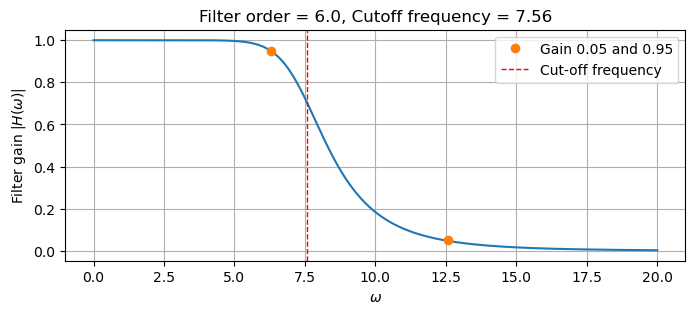

In [8]:
omega_axis = np.linspace(0,20,1000)
gain_pass_band = 0.95
omega_pass_band = 1*2*np.pi
gain_stop_band = 0.05
omega_stop_band = 2*2*np.pi

# Calculate filter order
n = np.log((1/gain_pass_band**2-1)/(1/gain_stop_band**2-1))/ (2*np.log(omega_pass_band/omega_stop_band))
n  = np.ceil(n)

# Calculate cut-off frequency
omega_cutoff = omega_pass_band / (( 1/gain_pass_band**2-1)**(1/2/n))

# Filter function |H(omega)|
amplitude_response = 1.0 /np.sqrt(( 1.0 + ( omega_axis/omega_cutoff)**(2.0*n)))

plt.figure(figsize=(8,3))
plt.plot(omega_axis,amplitude_response)
plt.plot([omega_pass_band, omega_stop_band],[gain_pass_band, gain_stop_band],'o',label='Gain 0.05 and 0.95')
plt.axvline(omega_cutoff,color ='r',linewidth=1,linestyle='--',label='Cut-off frequency')
plt.grid()
plt.legend()
plt.xlabel(r'$\omega$')
plt.ylabel('Filter gain $|H(\omega)|$')
plt.title(('Filter order = ' + str(n) + ', Cutoff frequency = ' + str(np.around(100*omega_cutoff)/100)))
plt.show()


The figure above confirms that the filter is behaving as expected. The curve will not perfectly pass through the points since the filter order needs to be an integer. 

Try to set the stopband frequency lower (e.g. 1.5 Hz), and see how the filter order changes.

## Filter frequency response

We will now study how to filter signals using a Butterworth filter implemented in SciPy.signal.
The following python code can obtain a Butterworth filter. We define an analog filter since we want to study the frequency response corresponding to continuous time.



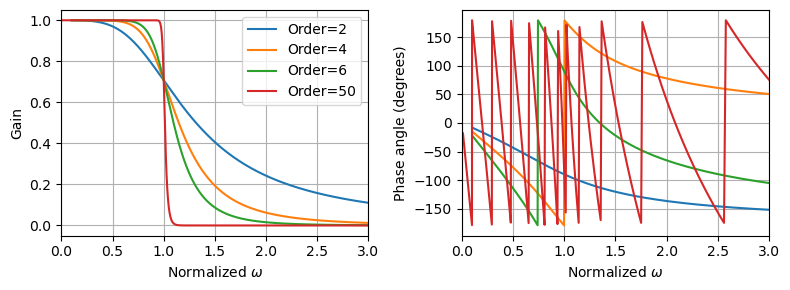

In [9]:
from scipy import signal as spsp
omega_cutoff = 1
n_plot = [2, 4, 6,50]

fig, axs = plt.subplots(1,2,figsize=(8,3))

for n in n_plot:
    b, a = spsp.butter(n,omega_cutoff, analog=True) # Obtain the filter coefficients (here, cut-off is given in rad/s)

    omega_axis, frequency_response = spsp.freqs(b,a,worN = 1000) # Obtain frequency response function
    
    axs[0].plot( omega_axis,np.abs(frequency_response),label = 'Order=' + str(n))
    axs[1].plot( omega_axis,np.angle(frequency_response)*360/2/np.pi)
    
axs[0].legend()
axs[0].grid()
axs[0].set_xlim(0,3)
axs[0].set_ylabel('Gain')
axs[0].set_xlabel('Normalized $\omega$')

axs[1].grid()
axs[1].set_xlim(0,3)
axs[1].set_ylabel('Phase angle (degrees)')
axs[1].set_xlabel('Normalized $\omega$')

fig.tight_layout()
plt.show()

We see that the obtained frequency response functions correspond perfectly to the results presented earlier in this note. The figure also shows the phase angle of the filter. The phase will delay between the original signal and the filtered signal. The phase angles of the frequency components may create severe artefacts, and it is, therefore, necessary to study this further. Let us generate a single harmonic signal and add some white noise to it.

## Filtering of a harmonic signal with noise



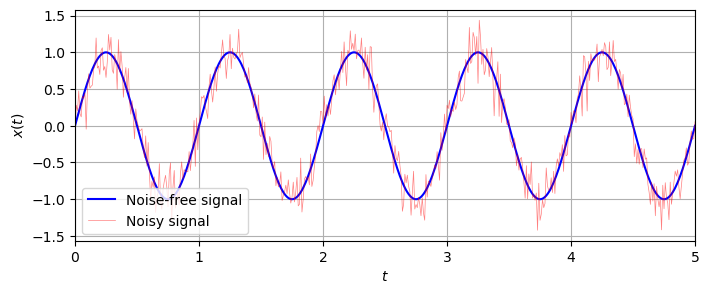

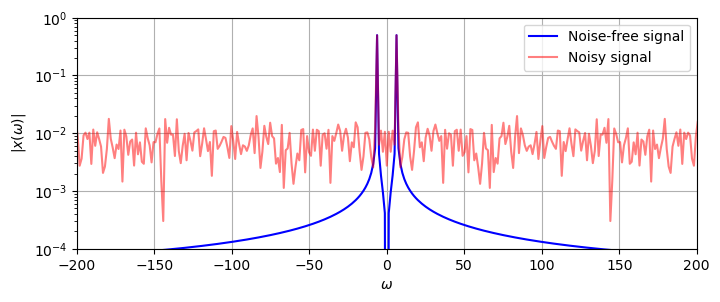

In [10]:
t = np.linspace(0,5,501)
N=len(t)
dt=t[1]-t[0]
f = 1.0

x = np.sin(2*np.pi*f*t)
noise= np.random.normal(size = t.shape[0])*0.2
x_noisy = x + noise

plt.figure(figsize=(8,3))
plt.plot(t,x,color='b',label='Noise-free signal')
plt.plot(t,x_noisy,color='r',alpha=0.5,linewidth=0.5,label='Noisy signal')
plt.xlabel(r'$t$')
plt.ylabel(r'$x(t)$')
plt.xlim(0,t[-1])
plt.grid()
plt.legend()

x_fft = np.fft.fft(x)/N # DFT
x_fft = np.fft.fftshift(x_fft) # Shift elements in vector, goes from [-omega,...,0,...+omega]

x_noisy_fft = np.fft.fft(x_noisy)/N # DFT
x_noisy_fft = np.fft.fftshift(x_noisy_fft) # Shift elements in vector, goes from [-omega,...,0,...+omega]

f_fft = np.fft.fftfreq(N, d=dt) # Frequency axis in Hz
f_fft_shift = np.fft.fftshift(f_fft)
omega_fft_shift=f_fft_shift*2*np.pi # Convert to rad/s

plt.figure(figsize=(8, 3))
plt.plot(omega_fft_shift,np.abs(x_fft),color='b',label='Noise-free signal')
plt.plot(omega_fft_shift,np.abs(x_noisy_fft),color='r',alpha=0.5,label='Noisy signal')
plt.xlim(-200,200)
plt.ylabel(r'$|x(\omega)|$')
plt.xlabel(r'$\omega$')
plt.legend()
plt.yscale('log')
plt.ylim(1e-4,1e0)
plt.grid()


Let us design a filter to remove some of the white noise. We can use a third-order filter with a cutoff frequency of 3 Hz and see what happens. It is vital to notice that the filter obtained above is an analogue filter. We cannot use this directly since we have a discrete signal and need to get the coefficients for the discrete filter. Also, note that frequencies in Hz are inputs for the digital filter, while frequencies in rad/s are used for the analogue filter.

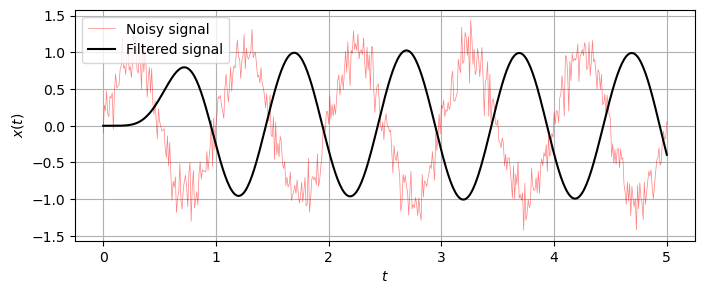

In [18]:
n = 6
f_cutoff = 1.5 # Hz

fs = 1/(t[1]-t[0])

sos = spsp.butter(n,f_cutoff,"low", fs=fs, output='sos')  # Cut-off is given in Hz
x_noisy_filt = spsp.sosfilt(sos,x_noisy)

plt.figure(figsize=(8,3))
plt.plot(t,x_noisy,color='r',alpha=0.5,linewidth=0.5,label='Noisy signal')
plt.plot(t,x_noisy_filt,color='k',label = 'Filtered signal')
plt.xlabel(r'$t$')
plt.ylabel(r'$x(t)$')
plt.grid()
plt.legend()


The figure above shows most of the noise has been removed and that the signal amplitude is unchanged. However, the apparent phase angle between the unfiltered and the filtered signal is an artefact that is not appreciated.

We can also see a large discrepancy at the beginning of the time series. We, unfortunately, don't know the signal history before $t=0$, and the filtering algorithm assumes that the signal is zero when $t<0$. Inaccuracies are thus introduced at the beginning of the filtered signal. However, the inaccuracy will vanish as the filtered signal mainly depends on the recent signal history. Therefore, we must expect that the filtered signal is inaccurate in the beginning for a duration corresponding to the time interval that the filter's impulse response lasts.

A frequently used approach to improve the filter's performance is to filter the signal two times. The signal is first filtered, as shown above. Then the signal is flipped and filtered backward to introduce the same phase shifts in the opposite direction. The idea is that filtering the signal two times will cancel delays caused by the phase angle. Let's use this approach on our signal.  

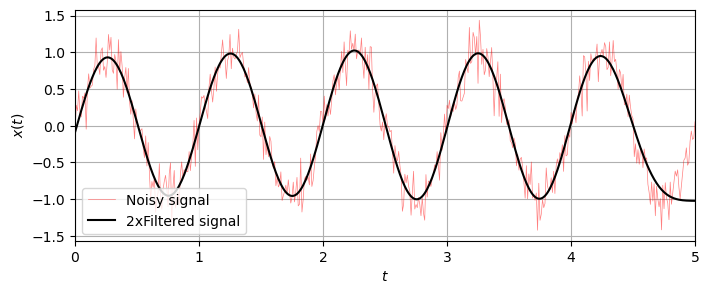

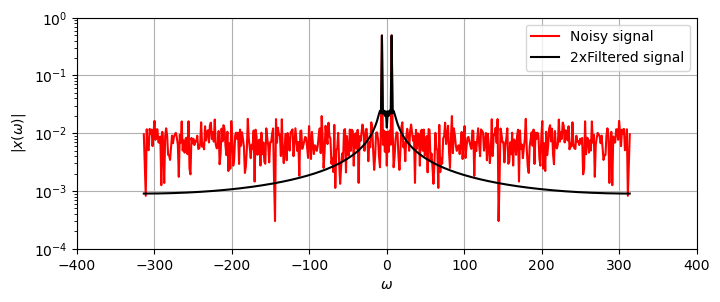

In [20]:
x_noisy_filtfilt = spsp.sosfiltfilt(sos, x_noisy)

plt.figure(figsize=(8,3))
plt.plot(t,x_noisy,color='r',alpha=0.5,linewidth=0.5,label='Noisy signal')
plt.plot(t,x_noisy_filtfilt,color='k',label = '2xFiltered signal')
plt.xlabel(r'$t$')
plt.ylabel(r'$x(t)$')
plt.xlim(0,5)
plt.grid()
plt.legend()

x_noisy_filtfilt_fft = np.fft.fft(x_noisy_filtfilt)/N # DFT
x_noisy_filtfilt_fft = np.fft.fftshift(x_noisy_filtfilt_fft) # Shift elements in vector, goes from [-omega,...,0,...+omega]

plt.figure(figsize=(8,3))
plt.plot(omega_fft_shift,np.abs(x_noisy_fft),color='r',label='Noisy signal')
plt.plot(omega_fft_shift,np.abs(x_noisy_filtfilt_fft),color='k',label='2xFiltered signal')
plt.xlim(-400,400)
plt.ylim(1e-4,1e0)
plt.ylabel(r'$|x(\omega)|$')
plt.xlabel(r'$\omega$')
plt.legend()
plt.yscale('log')
plt.grid()


This gives a good result, but we still have transient effects due to the filtering. This is unavoidable. It is therefore often wise to cut the time series before using it in further analysis.